In [4]:
# =====================
# Packages
# =====================

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import copy
import matplotlib.pyplot as plt

In [5]:
# =====================
# Actor-Critic Networks
# =====================

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.max_action * torch.tanh(self.layer3(x))


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Q1
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)
        # Q2
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)
        q1 = torch.relu(self.l1(xu))
        q1 = torch.relu(self.l2(q1))
        q1 = self.l3(q1)
        q2 = torch.relu(self.l4(xu))
        q2 = torch.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)
        q1 = torch.relu(self.l1(xu))
        q1 = torch.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1

In [6]:
# =====================
# Replay Buffer
# =====================

class ReplayBuffer:
    def __init__(self, max_size=1000000):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, float(done)))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.stack, zip(*batch))
        return (
            torch.FloatTensor(states),
            torch.FloatTensor(actions),
            torch.FloatTensor(rewards).unsqueeze(1),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones).unsqueeze(1),
        )

    def size(self):
        return len(self.buffer)

In [7]:
# =====================
# TD3 Agent
# =====================

class TD3Agent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = copy.deepcopy(self.actor)
        self.critic = Critic(state_dim, action_dim)
        self.critic_target = copy.deepcopy(self.critic)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=3e-4)
        self.max_action = max_action
        self.discount = 0.99
        self.tau = 0.005
        self.policy_noise = 0.2
        self.noise_clip = 0.5
        self.policy_delay = 2
        self.total_it = 0

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1))
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=128):
        if replay_buffer.size() < batch_size:
            return
        self.total_it += 1
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)
        with torch.no_grad():
            noise = (torch.randn_like(action) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (1 - done) * self.discount * target_Q
        current_Q1, current_Q2 = self.critic(state, action)
        critic_loss = nn.MSELoss()(current_Q1, target_Q) + nn.MSELoss()(current_Q2, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        if self.total_it % self.policy_delay == 0:
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


Episode 1, Reward: -1718.34
Episode 2, Reward: -1567.33
Episode 3, Reward: -1218.93
Episode 4, Reward: -1368.55
Episode 5, Reward: -1569.97
Episode 6, Reward: -1932.41
Episode 7, Reward: -1500.36
Episode 8, Reward: -1859.09
Episode 9, Reward: -1517.19
Episode 10, Reward: -1423.67
Episode 11, Reward: -1365.90
Episode 12, Reward: -1490.60
Episode 13, Reward: -1702.33
Episode 14, Reward: -1250.82
Episode 15, Reward: -1331.15
Episode 16, Reward: -1419.65
Episode 17, Reward: -1403.78
Episode 18, Reward: -1351.36
Episode 19, Reward: -1421.13
Episode 20, Reward: -1219.78
Episode 21, Reward: -1313.76
Episode 22, Reward: -1280.90
Episode 23, Reward: -1174.62
Episode 24, Reward: -1088.02
Episode 25, Reward: -1306.19
Episode 26, Reward: -1108.18
Episode 27, Reward: -1196.77
Episode 28, Reward: -1234.06
Episode 29, Reward: -1122.71
Episode 30, Reward: -1255.17
Episode 31, Reward: -1157.17
Episode 32, Reward: -1126.21
Episode 33, Reward: -1175.55
Episode 34, Reward: -1130.10
Episode 35, Reward: -10

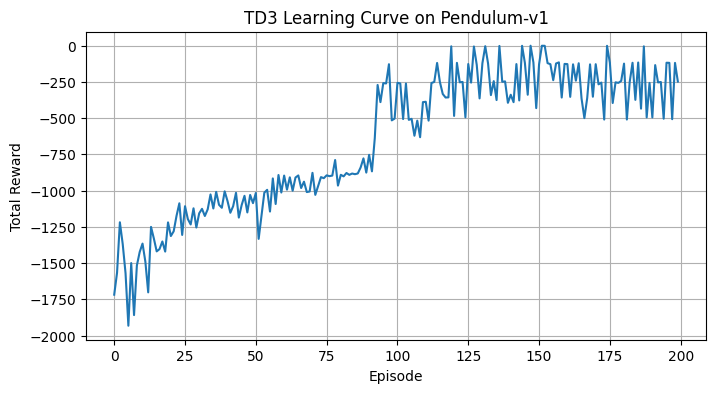

In [8]:
# =====================
# Training Script
# =====================

env = gym.make("Pendulum-v1", g=9.81)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

agent = TD3Agent(state_dim, action_dim, max_action)
replay_buffer = ReplayBuffer()

episodes = 200
episode_rewards = []

for ep in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    for t in range(200):
        action = agent.select_action(state)
        action = (action + np.random.normal(0, 0.1, size=action_dim)).clip(-max_action, max_action)
        next_state, reward, done, trunc, _ = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        agent.train(replay_buffer)
        state = next_state
        total_reward += reward
        if done or trunc:
            break
    episode_rewards.append(total_reward)
    print(f"Episode {ep+1}, Reward: {total_reward:.2f}")

env.close()